In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from itertools import product
from sklearn.model_selection import train_test_split
from pathlib import Path
import random
from tqdm import tqdm
import xml.etree.ElementTree as ET
import cv2
import plotly.graph_objs as go
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
import json
from torch.utils.data import Dataset
import torch
import cv2
import torch.nn as nn
import torch.nn.functional as F

In [149]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        self.N = torch.distributions.Normal(0, 1)

        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0


        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 3, stride=2, padding=0),
            nn.ReLU(True)

        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section


        self.conditional_pipe = nn.Sequential(
            nn.Linear(2320, fc2_input_dim),
            nn.ReLU(True),
            nn.Linear(fc2_input_dim, encoded_space_dim)
        )


        self.encoder_lin = nn.Sequential(
            nn.Linear(32, fc2_input_dim),
            nn.ReLU(True),
            nn.Linear(fc2_input_dim, encoded_space_dim)
        )
        self.encoder_lin1 = nn.Sequential(
            nn.Linear(32, fc2_input_dim),
            nn.ReLU(True),
            nn.Linear(fc2_input_dim, encoded_space_dim)
        )
        
    def forward(self, x, c):
        #print("Encoder input: ", np.shape(x))
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = torch.cat([x, c], 1).float()

        x = self.conditional_pipe(x)

        mu =  self.encoder_lin(x)
        sigma = torch.exp(self.encoder_lin1(x))


        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()

        return z
    
    
    
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim+16, fc2_input_dim),
            nn.ReLU(True),
            nn.Linear(fc2_input_dim, 3 * 3 * fc2_input_dim),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(fc2_input_dim, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(fc2_input_dim, 128, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2,  padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x, labels, c):

        x = inputs = torch.cat([x, labels.float()], 1).float()

        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x


### Define the loss function
loss_fn = torch.nn.MSELoss()
loss_latent = torch.nn.L1Loss()



### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
dim = 32

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=dim,fc2_input_dim=512)
decoder = Decoder(encoded_space_dim=dim,fc2_input_dim=512)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=48, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=4608, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(512, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(512, 128, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=T

In [150]:
decoder.load_state_dict(torch.load("decoder.dict"))


<All keys matched successfully>

In [200]:
def generate_label(malign):
    
    label = np.zeros((1, 16))
    
    comp = np.random.randint(4)
    echo = np.random.randint(4)
    margins = np.random.randint(4)
    calc = np.random.randint(3)
    
    label[0,comp] = 1
    label[0,3+echo] = 1
    label[0,7+margins] = 1
    label[0,12+calc] = 1
    label[0, 15] = malign
    
    return label

# 0 1 2 3 |4 5 6 7 | 10 11 12 13 | 15 16


print(generate_label(1))

[[1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.]]


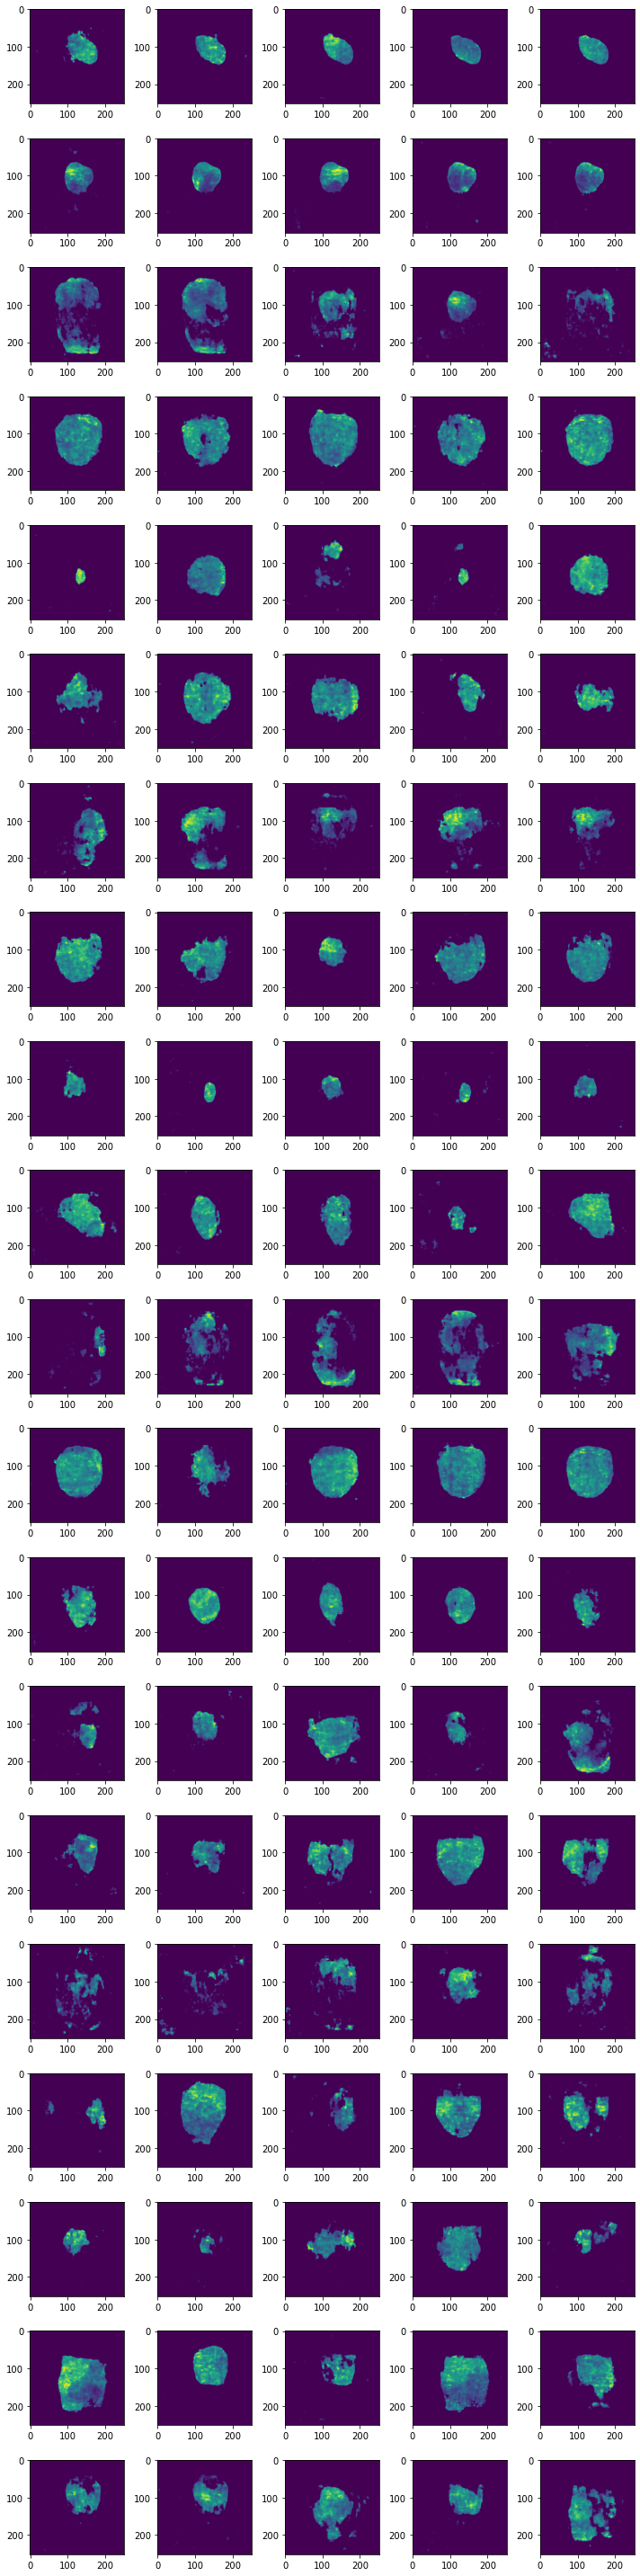

malignant


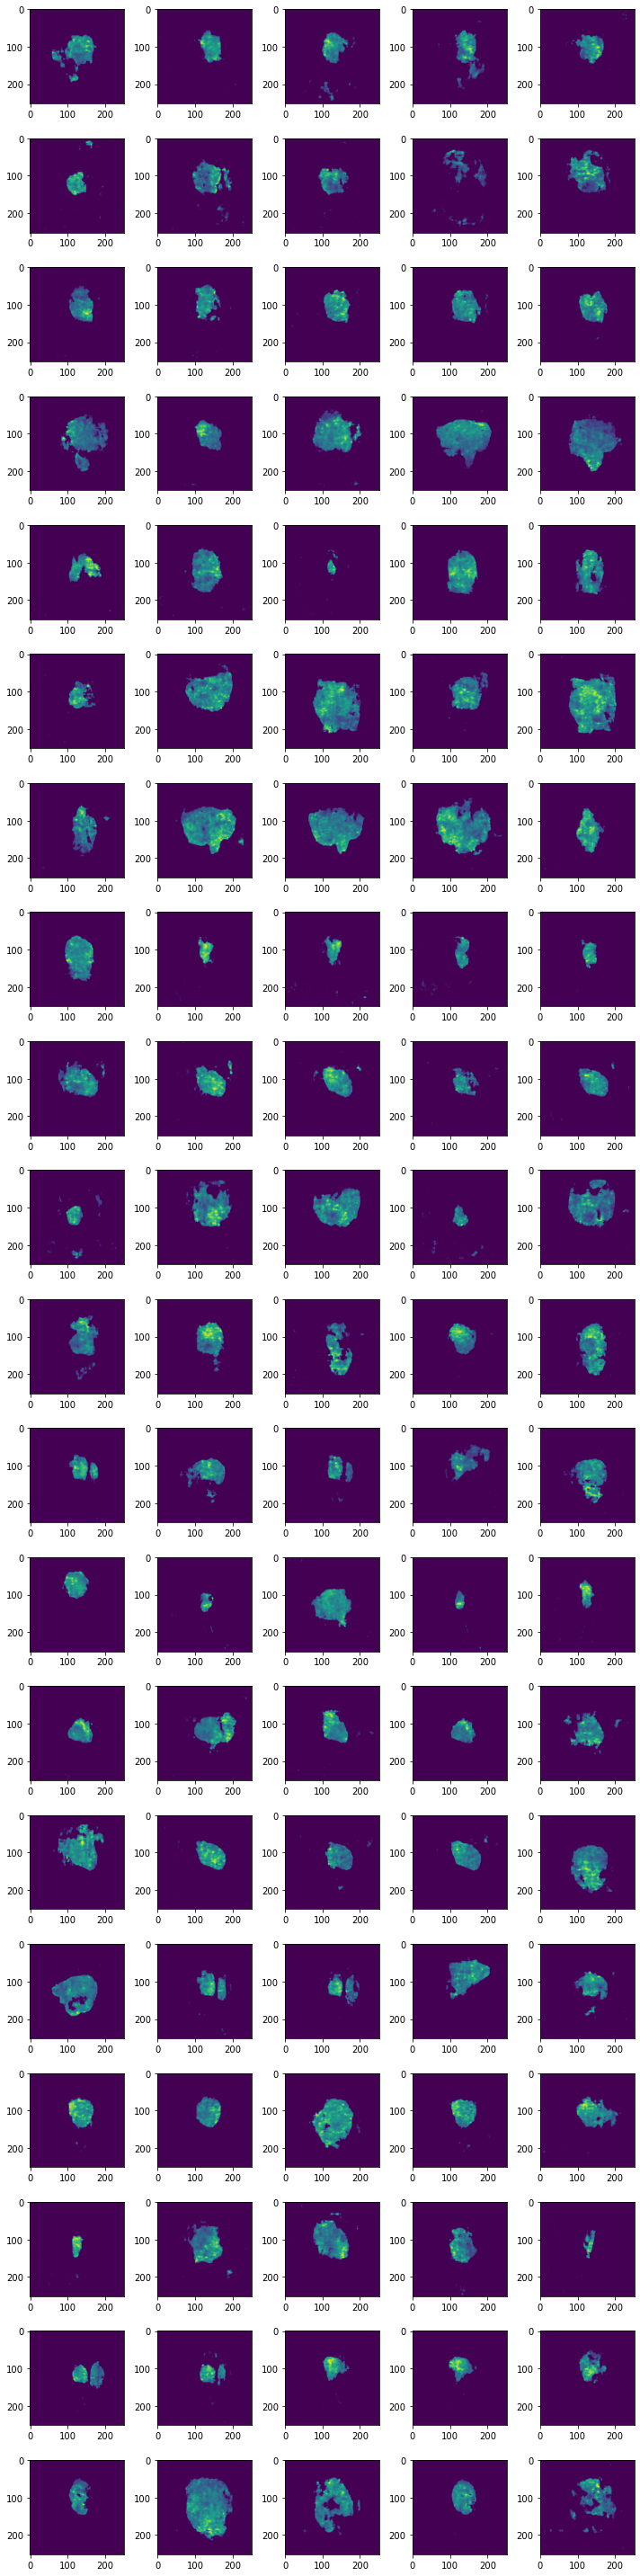

In [201]:
fig, ax = plt.subplots(20, 5, figsize=(10, 40))
fig.set_tight_layout(True)
for c in range(20): # with "_" we just ignore the labels (the second element of the dataloader tuple)
    # Move tensor to the proper device
    labels = torch.FloatTensor(generate_label(0)).to(device)
    #print("Random data shape", np.shape(random_data), "; data[labels] ", np.shape(data["labels"]))
    for i in range(5):
        latent = torch.FloatTensor(np.random.randn(1, dim)).to(device)
        img_recon = decoder(latent, labels)
        img_recon = img_recon.detach().cpu().numpy()
        ax[c, i].imshow(img_recon[0, 0, :, :])
plt.tight_layout()
plt.show()

print("malignant")


fig, ax = plt.subplots(20, 5, figsize=(10, 40))
fig.set_tight_layout(True)
for c in range(20): # with "_" we just ignore the labels (the second element of the dataloader tuple)
    # Move tensor to the proper device
    labels = torch.FloatTensor(generate_label(1)).to(device)
    #print("Random data shape", np.shape(random_data), "; data[labels] ", np.shape(data["labels"]))
    for i in range(5):
        latent = torch.FloatTensor(np.random.randn(1, dim)).to(device)
        img_recon = decoder(latent, labels)
        img_recon = img_recon.detach().cpu().numpy()
        ax[c, i].imshow(img_recon[0, 0, :, :])
plt.tight_layout()



    